<a href="https://colab.research.google.com/github/MakeevIlia/Computer-Vision/blob/main/Cleaned_Dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
from tqdm import tqdm
import os
import zipfile

val_percent = 0.2


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

with zipfile.ZipFile('/content/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/data')

data_root = '/content/data/plates'

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % int(1/ val_percent) != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5377.64it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import torchvision
from torchvision import transforms, models

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transforms_org = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transforms_mod = transforms.Compose([
    transforms.RandomResizedCrop(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.8),
    transforms.RandomVerticalFlip(p = 0.8),
    transforms.RandomInvert(p=0.5),
    transforms.ColorJitter(0.1, 2, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

orig = 5
modif = 20
batch_size = 16


train_ds = []
for i in range(modif):
  train_dataset_mod = torchvision.datasets.ImageFolder(train_dir, train_transforms_mod)
  train_ds.append(train_dataset_mod)

for i in range(orig):
  train_dataset_org = torchvision.datasets.ImageFolder(train_dir, train_transforms_org)
  train_ds.append(train_dataset_org)

train_dataset = torch.utils.data.ConcatDataset(train_ds)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    test_accuracy_history = []
    test_loss_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            if phase == 'val':
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

        if phase == 'val':
          test_loss_history.append(epoch_loss)
          test_accuracy_history.append(epoch_acc.cpu())

    return test_loss_history, test_accuracy_history

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 10),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(10),

    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(5),

    torch.nn.Linear(5, 2),
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-1)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
torch.manual_seed(0);
loss_history, acc_history = train_model(model, loss, optimizer, scheduler, num_epochs=70);

Epoch 0/69:


100%|██████████| 47/47 [00:05<00:00,  8.68it/s]

train Loss: 0.5584 Acc: 0.6962



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 1.8193 Acc: 0.5000
Epoch 1/69:



100%|██████████| 47/47 [00:05<00:00,  8.04it/s]

train Loss: 0.3397 Acc: 0.8511



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 1.1170 Acc: 0.5000
Epoch 2/69:



100%|██████████| 47/47 [00:05<00:00,  9.03it/s]

train Loss: 0.3016 Acc: 0.8987



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.7837 Acc: 0.7000
Epoch 3/69:



100%|██████████| 47/47 [00:07<00:00,  6.15it/s]

train Loss: 0.2591 Acc: 0.8986



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

val Loss: 0.9908 Acc: 0.5000
Epoch 4/69:



100%|██████████| 47/47 [00:05<00:00,  8.50it/s]

train Loss: 0.1997 Acc: 0.9215



100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

val Loss: 0.5699 Acc: 0.8000
Epoch 5/69:



100%|██████████| 47/47 [00:05<00:00,  8.22it/s]

train Loss: 0.2646 Acc: 0.9075



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.7342 Acc: 0.6000
Epoch 6/69:



100%|██████████| 47/47 [00:05<00:00,  8.97it/s]

train Loss: 0.2129 Acc: 0.9132



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

val Loss: 0.8262 Acc: 0.6000
Epoch 7/69:



100%|██████████| 47/47 [00:06<00:00,  7.13it/s]

train Loss: 0.2503 Acc: 0.9016



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

val Loss: 0.6469 Acc: 0.7000
Epoch 8/69:



100%|██████████| 47/47 [00:05<00:00,  9.01it/s]

train Loss: 0.2165 Acc: 0.9147



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

val Loss: 1.0588 Acc: 0.6000
Epoch 9/69:



100%|██████████| 47/47 [00:06<00:00,  7.07it/s]

train Loss: 0.2493 Acc: 0.9014



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

val Loss: 0.8514 Acc: 0.5000
Epoch 10/69:



100%|██████████| 47/47 [00:05<00:00,  9.18it/s]

train Loss: 0.2452 Acc: 0.8989



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.9234 Acc: 0.6000
Epoch 11/69:



100%|██████████| 47/47 [00:06<00:00,  6.99it/s]

train Loss: 0.2409 Acc: 0.9081



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.9067 Acc: 0.5000
Epoch 12/69:



100%|██████████| 47/47 [00:05<00:00,  8.93it/s]

train Loss: 0.2486 Acc: 0.8948



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.7070 Acc: 0.8000
Epoch 13/69:



100%|██████████| 47/47 [00:06<00:00,  7.10it/s]

train Loss: 0.2349 Acc: 0.9107



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

val Loss: 1.1891 Acc: 0.5000
Epoch 14/69:



100%|██████████| 47/47 [00:05<00:00,  9.02it/s]

train Loss: 0.2131 Acc: 0.9122



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

val Loss: 1.0309 Acc: 0.6000
Epoch 15/69:



100%|██████████| 47/47 [00:06<00:00,  7.20it/s]

train Loss: 0.2129 Acc: 0.9200



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

val Loss: 0.9740 Acc: 0.5000
Epoch 16/69:



100%|██████████| 47/47 [00:05<00:00,  8.88it/s]

train Loss: 0.2039 Acc: 0.9092



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.9705 Acc: 0.6000
Epoch 17/69:



100%|██████████| 47/47 [00:06<00:00,  7.13it/s]

train Loss: 0.2156 Acc: 0.9094



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

val Loss: 0.9985 Acc: 0.7000
Epoch 18/69:



100%|██████████| 47/47 [00:05<00:00,  8.71it/s]

train Loss: 0.2250 Acc: 0.9119



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.8777 Acc: 0.6000
Epoch 19/69:



100%|██████████| 47/47 [00:06<00:00,  7.20it/s]

train Loss: 0.2078 Acc: 0.9200



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.8599 Acc: 0.8000
Epoch 20/69:



100%|██████████| 47/47 [00:05<00:00,  9.09it/s]

train Loss: 0.1659 Acc: 0.9335



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

val Loss: 0.7724 Acc: 0.7000
Epoch 21/69:



100%|██████████| 47/47 [00:06<00:00,  7.28it/s]

train Loss: 0.1663 Acc: 0.9362



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.8295 Acc: 0.7000
Epoch 22/69:



100%|██████████| 47/47 [00:05<00:00,  9.01it/s]

train Loss: 0.1700 Acc: 0.9348



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5559 Acc: 0.7000
Epoch 23/69:



100%|██████████| 47/47 [00:05<00:00,  8.11it/s]

train Loss: 0.1995 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

val Loss: 0.6286 Acc: 0.6000
Epoch 24/69:



100%|██████████| 47/47 [00:05<00:00,  8.19it/s]

train Loss: 0.2001 Acc: 0.9174



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

val Loss: 0.9442 Acc: 0.6000
Epoch 25/69:



100%|██████████| 47/47 [00:05<00:00,  8.99it/s]

train Loss: 0.1529 Acc: 0.9371



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

val Loss: 0.6740 Acc: 0.7000
Epoch 26/69:



100%|██████████| 47/47 [00:06<00:00,  7.17it/s]

train Loss: 0.2325 Acc: 0.9174



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.8358 Acc: 0.5000
Epoch 27/69:



100%|██████████| 47/47 [00:05<00:00,  8.94it/s]

train Loss: 0.1621 Acc: 0.9415



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

val Loss: 1.2393 Acc: 0.7000
Epoch 28/69:



100%|██████████| 47/47 [00:06<00:00,  7.08it/s]

train Loss: 0.2102 Acc: 0.9185



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

val Loss: 0.5902 Acc: 0.7000
Epoch 29/69:



100%|██████████| 47/47 [00:05<00:00,  8.99it/s]

train Loss: 0.1997 Acc: 0.9335



100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

val Loss: 0.6747 Acc: 0.5000
Epoch 30/69:



100%|██████████| 47/47 [00:06<00:00,  7.08it/s]

train Loss: 0.1456 Acc: 0.9481



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

val Loss: 0.6834 Acc: 0.7000
Epoch 31/69:



100%|██████████| 47/47 [00:05<00:00,  8.89it/s]

train Loss: 0.1706 Acc: 0.9305



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

val Loss: 0.5695 Acc: 0.7000
Epoch 32/69:



100%|██████████| 47/47 [00:06<00:00,  7.09it/s]

train Loss: 0.1813 Acc: 0.9291



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

val Loss: 0.5993 Acc: 0.8000
Epoch 33/69:



100%|██████████| 47/47 [00:05<00:00,  8.70it/s]


train Loss: 0.1569 Acc: 0.9320


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.6920 Acc: 0.5000
Epoch 34/69:



100%|██████████| 47/47 [00:06<00:00,  7.17it/s]

train Loss: 0.1872 Acc: 0.9358



100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

val Loss: 0.7650 Acc: 0.7000
Epoch 35/69:



100%|██████████| 47/47 [00:05<00:00,  8.84it/s]

train Loss: 0.1799 Acc: 0.9386



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 1.0857 Acc: 0.7000
Epoch 36/69:



100%|██████████| 47/47 [00:06<00:00,  7.23it/s]

train Loss: 0.1837 Acc: 0.9267



100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

val Loss: 1.0515 Acc: 0.7000
Epoch 37/69:



100%|██████████| 47/47 [00:05<00:00,  8.77it/s]

train Loss: 0.1413 Acc: 0.9478



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 1.3756 Acc: 0.6000
Epoch 38/69:



100%|██████████| 47/47 [00:06<00:00,  7.43it/s]

train Loss: 0.1825 Acc: 0.9309



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

val Loss: 0.9243 Acc: 0.6000
Epoch 39/69:



100%|██████████| 47/47 [00:05<00:00,  8.91it/s]

train Loss: 0.1469 Acc: 0.9508



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

val Loss: 0.9551 Acc: 0.6000
Epoch 40/69:



100%|██████████| 47/47 [00:06<00:00,  7.82it/s]

train Loss: 0.1480 Acc: 0.9441



100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

val Loss: 0.8846 Acc: 0.6000
Epoch 41/69:



100%|██████████| 47/47 [00:05<00:00,  8.33it/s]

train Loss: 0.1829 Acc: 0.9280



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

val Loss: 0.8276 Acc: 0.6000
Epoch 42/69:



100%|██████████| 47/47 [00:05<00:00,  8.73it/s]

train Loss: 0.1628 Acc: 0.9282



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.9866 Acc: 0.7000
Epoch 43/69:



100%|██████████| 47/47 [00:06<00:00,  7.72it/s]

train Loss: 0.1933 Acc: 0.9223



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.7690 Acc: 0.7000
Epoch 44/69:



100%|██████████| 47/47 [00:05<00:00,  9.07it/s]

train Loss: 0.1521 Acc: 0.9386



100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

val Loss: 0.8684 Acc: 0.7000
Epoch 45/69:



100%|██████████| 47/47 [00:06<00:00,  7.11it/s]

train Loss: 0.1737 Acc: 0.9309



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.9117 Acc: 0.7000
Epoch 46/69:



100%|██████████| 47/47 [00:05<00:00,  8.83it/s]

train Loss: 0.2128 Acc: 0.9092



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.8095 Acc: 0.7000
Epoch 47/69:



100%|██████████| 47/47 [00:07<00:00,  6.47it/s]

train Loss: 0.1756 Acc: 0.9347



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.8386 Acc: 0.7000
Epoch 48/69:



100%|██████████| 47/47 [00:05<00:00,  9.08it/s]

train Loss: 0.1740 Acc: 0.9347



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.9744 Acc: 0.7000
Epoch 49/69:



100%|██████████| 47/47 [00:06<00:00,  7.17it/s]

train Loss: 0.1490 Acc: 0.9415



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 1.0427 Acc: 0.7000
Epoch 50/69:



100%|██████████| 47/47 [00:05<00:00,  9.05it/s]

train Loss: 0.1878 Acc: 0.9202



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.6673 Acc: 0.7000
Epoch 51/69:



100%|██████████| 47/47 [00:06<00:00,  7.09it/s]

train Loss: 0.1833 Acc: 0.9253



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

val Loss: 0.8527 Acc: 0.7000
Epoch 52/69:



100%|██████████| 47/47 [00:05<00:00,  8.70it/s]

train Loss: 0.1656 Acc: 0.9345



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.6713 Acc: 0.7000
Epoch 53/69:



100%|██████████| 47/47 [00:06<00:00,  7.12it/s]

train Loss: 0.1774 Acc: 0.9280



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

val Loss: 1.0166 Acc: 0.7000
Epoch 54/69:



100%|██████████| 47/47 [00:05<00:00,  8.72it/s]

train Loss: 0.1478 Acc: 0.9413



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

val Loss: 0.7892 Acc: 0.7000
Epoch 55/69:



100%|██████████| 47/47 [00:06<00:00,  7.18it/s]

train Loss: 0.1708 Acc: 0.9345



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.8497 Acc: 0.6000
Epoch 56/69:



100%|██████████| 47/47 [00:05<00:00,  8.80it/s]

train Loss: 0.1579 Acc: 0.9415



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

val Loss: 0.9097 Acc: 0.7000
Epoch 57/69:



100%|██████████| 47/47 [00:06<00:00,  7.12it/s]

train Loss: 0.1442 Acc: 0.9386



100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

val Loss: 0.7542 Acc: 0.6000
Epoch 58/69:



100%|██████████| 47/47 [00:05<00:00,  8.72it/s]

train Loss: 0.1657 Acc: 0.9415



100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

val Loss: 0.6709 Acc: 0.6000
Epoch 59/69:



100%|██████████| 47/47 [00:06<00:00,  7.68it/s]

train Loss: 0.1659 Acc: 0.9373



100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

val Loss: 0.7053 Acc: 0.6000
Epoch 60/69:



100%|██████████| 47/47 [00:05<00:00,  8.29it/s]

train Loss: 0.1594 Acc: 0.9441



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.6737 Acc: 0.7000
Epoch 61/69:



100%|██████████| 47/47 [00:05<00:00,  8.50it/s]

train Loss: 0.1345 Acc: 0.9402



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.6939 Acc: 0.7000
Epoch 62/69:



100%|██████████| 47/47 [00:06<00:00,  7.63it/s]

train Loss: 0.1578 Acc: 0.9413



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

val Loss: 0.7379 Acc: 0.6000
Epoch 63/69:



100%|██████████| 47/47 [00:05<00:00,  8.65it/s]

train Loss: 0.1999 Acc: 0.9174



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6515 Acc: 0.7000
Epoch 64/69:



100%|██████████| 47/47 [00:06<00:00,  7.22it/s]

train Loss: 0.1516 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.8121 Acc: 0.7000
Epoch 65/69:



100%|██████████| 47/47 [00:05<00:00,  9.01it/s]

train Loss: 0.1668 Acc: 0.9333



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.7181 Acc: 0.7000
Epoch 66/69:



100%|██████████| 47/47 [00:06<00:00,  6.98it/s]

train Loss: 0.1638 Acc: 0.9413



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

val Loss: 0.7602 Acc: 0.7000
Epoch 67/69:



100%|██████████| 47/47 [00:05<00:00,  9.01it/s]

train Loss: 0.1635 Acc: 0.9293



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.7769 Acc: 0.7000
Epoch 68/69:



100%|██████████| 47/47 [00:06<00:00,  6.99it/s]

train Loss: 0.1434 Acc: 0.9373



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

val Loss: 0.6493 Acc: 0.7000
Epoch 69/69:



100%|██████████| 47/47 [00:05<00:00,  8.96it/s]

train Loss: 0.1644 Acc: 0.9415



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.9213 Acc: 0.6000


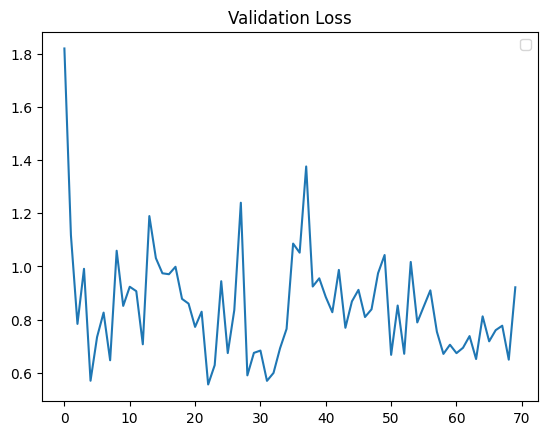

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.title('Validation Loss');

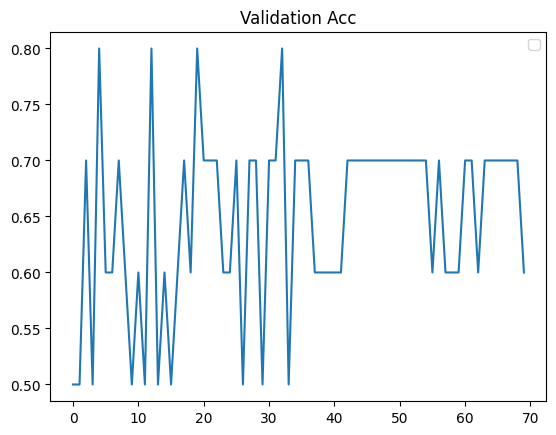

In [ ]:
plt.plot(acc_history)
plt.legend()
plt.title('Validation Acc');

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: ignored

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 47/47 [00:07<00:00,  6.43it/s]


In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.to_csv('/content/submission.csv')

<ipython-input-77-723e859e93a5>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


In [ ]:
!rm -rf train val test

In [ ]:
# More images check
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

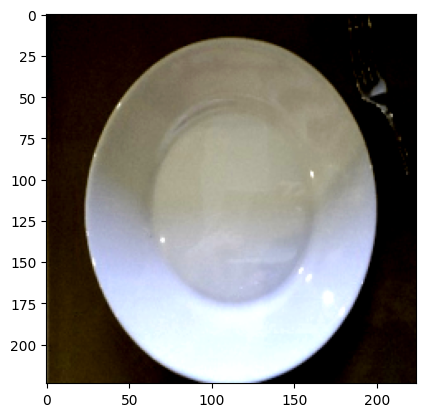

In [ ]:
X_batch, y_batch = next(iter(mod_dataloader))

plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [ ]:
# Train Image check
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# More images check
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(mod_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
# Test Image check
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)